# Machine Learning flow (To Predict Core width and core height)
## Import relevant libraries and dataset
 - Dataset is created by PNRdatabase jupyter notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_csv('PNRdatabase3.csv') # load dataset (csv file) with pandas

## Define features (X) and targets (y)
 - Define X as feature columns
 - Define y as target column CoreWidth
 - Define z as target column CoreHeight

In [2]:
# Drop all columns which will not be used in machine learning model, leaving feature and target columns
train = data.drop(['Violations','AntennaViolations','Type40LP','MetalStack','Date','RowDirection','DoubleBack','FlipFirstRow','StartfromFirstRow'],axis=1)

# Drop target columns, leaving feature columns
X = train.drop(['CoreHeight','CoreWidth'],axis=1)

# Define y and z to be target columns
y = train['CoreWidth']
z = train['CoreHeight']

## Look at distribution of targets
 - Check for presence of possible outliers

Text(0.5, 1.0, 'Distribution of CoreHeight')

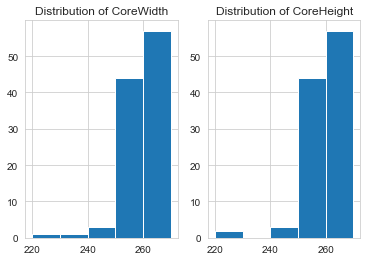

In [3]:
import seaborn as sns
sns.set_style('whitegrid')
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.hist(y, range=(220, 270), bins=5)
ax2.hist(z, range=(220, 270), bins=5)
ax1.set_title('Distribution of CoreWidth')
ax2.set_title('Distribution of CoreHeight')

In [4]:
from sklearn.model_selection import train_test_split

# split dataset into train set (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=41)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=41)

## Select the best features with feature selection

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

# function to return features with highest correlation to target
def select_columns(feature_cols,target_col,no_features=5):
    selector = SelectKBest(f_classif, k=no_features)
    X_new = selector.fit_transform(feature_cols,target_col)
    selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=X.columns)
    selected_columns = selected_features.columns[selected_features.var() != 0]
    return selected_columns
    
selected_columns_place = select_columns(train[X.columns],train['CoreHeight'])
selected_columns_route = select_columns(train[X.columns],train['CoreWidth'])

# print list of features with highest correlation to target
print(selected_columns_place)
print(selected_columns_route)

Index(['LayerM2', 'LayerFA', 'NetCount', 'RowCount', 'AspectRatio'], dtype='object')
Index(['LayerM2', 'LayerFA', 'NetCount', 'RowCount', 'AspectRatio'], dtype='object')


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: UserWarning: Features [11 12 13 15 16 17 18 21 22 23 26] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: UserWarning: Features [11 12 13 15 16 17 18 21 22 23 26] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
c:\users\asus\appdata\local\programs\python\python38\lib\site-pac

## Find best regression model from scikit-learn using k-fold cross validation
- Metrics used: root mean squared error
- number of folds: 10

In [6]:
from sklearn.linear_model import LinearRegression    
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor   
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

k=11

# list of regression models from sklearn
Regressors = [
    LinearRegression(),
    Ridge(max_iter=10000,random_state=k),
    Lasso(max_iter=10000,random_state=k),
    ElasticNet(max_iter=10000,random_state=k),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=k),
    SVR(max_iter=10000),
    GradientBoostingRegressor(random_state=k),
    RandomForestRegressor(random_state=k)
]

from sklearn.model_selection import cross_val_score

# initialize a high best score for CoreWidth and CoreHeight
best_score_width = 100
best_score_height = 100

# loop through regression model list to find the best scores
for regressor in Regressors:
    cv_results_width = -cross_val_score(regressor, X_train[selected_columns_route], y_train, scoring='neg_root_mean_squared_error', cv=10 )
    cv_results_height = -cross_val_score(regressor, X_train[selected_columns_place], z_train, scoring='neg_root_mean_squared_error', cv=10 )
    if best_score_width > cv_results_width.mean():
        best_score_width = cv_results_width.mean()
        best_regressor_width = regressor
    if best_score_height > cv_results_height.mean():
        best_score_height = cv_results_height.mean()
        best_regressor_height = regressor
    
# print best score and regression model
print('best score (width) is: ',best_score_width)
print('best regressor (width) is: ',best_regressor_width)
        
print('best score (height) is: ',best_score_height)
print('best regressor (height) is: ',best_regressor_height)

best score (width) is:  0.010679833933034347
best regressor (width) is:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
best score (height) is:  4.789827903522628e-13
best regressor (height) is:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


## Train and test best models with best values of hyperparameters
 - As best model (linear regression) does not have tunable hyperparameters, GridSearchCV is not carried out

In [7]:
from sklearn import metrics
linreg_width = LinearRegression()

# train model with train set 
linreg_width.fit(X_train,y_train)
y_pred = linreg_width.predict(X_test) # test model wih test set
print(y_pred)
print(y_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[253.25963674 253.25947399 263.91129763 263.91049303 263.91008362
 253.25961176 263.91004595 253.26039428 253.26173361 253.26081225
 253.25957121 253.26014733 263.90996352 263.91041894 263.90982067
 263.91107549 263.91024652 253.25923804 253.41799214 253.25918221
 263.90966156 263.91024439]
94     253.26
63     253.26
24     263.91
6      263.91
0      263.91
71     253.26
41     263.91
92     253.26
91     253.26
100    253.26
82     253.26
102    253.26
27     263.91
37     263.91
33     263.91
49     263.91
2      263.91
105    253.26
83     253.26
73     253.26
16     263.91
32     263.91
Name: CoreWidth, dtype: float64
0.03369036111277835


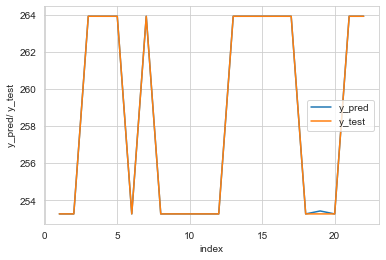

In [8]:
# plot graph of predited and actual values of CoreWidth
testlist = list(range(1,23))
plt.plot(testlist, y_pred)
plt.plot(testlist, y_test)
plt.xlabel('index')
plt.ylabel('y_pred/ y_test')
plt.legend(['y_pred','y_test'])

In [9]:
# train model with train set
linreg_height = LinearRegression()
linreg_height.fit(X_train,z_train)
z_pred = linreg_width.predict(X_test) # test model with test set
print(z_pred)
print(z_test)
print(np.sqrt(metrics.mean_squared_error(z_test, z_pred)))

[253.25963674 253.25947399 263.91129763 263.91049303 263.91008362
 253.25961176 263.91004595 253.26039428 253.26173361 253.26081225
 253.25957121 253.26014733 263.90996352 263.91041894 263.90982067
 263.91107549 263.91024652 253.25923804 253.41799214 253.25918221
 263.90966156 263.91024439]
94     253.26
63     253.26
24     263.34
6      263.34
0      263.34
71     253.26
41     263.34
92     253.26
91     253.26
100    253.26
82     253.26
102    253.26
27     263.34
37     263.34
33     263.34
49     263.34
2      263.34
105    253.26
83     253.26
73     253.26
16     263.34
32     263.34
Name: CoreHeight, dtype: float64
0.4046711006578264


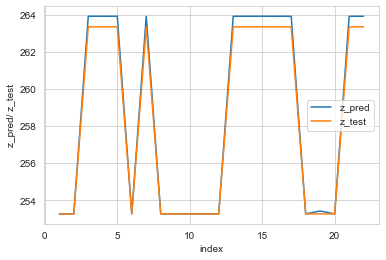

In [11]:
# plot graph of predited and actual values of CoreHeight
testlist = list(range(1,23))
plt.plot(testlist, z_pred)
plt.plot(testlist, z_test)
plt.xlabel('index')
plt.ylabel('z_pred/ z_test')
plt.legend(['z_pred','z_test'])